# Bayesian Learning

```{contents} Table of Contents
:depth: 3
```

## Frequentest viewpoint

The frequentest view of statistics assumes that a set of $n$ observations ($o_{1},o_{2},\cdots,o_{n}$) were generated by a sequence of corresponding $n$ random variables ($X_{1},X_{2},\cdots,X_{n}$). 
Importantly, the frequentest viewpoint assumes that any parameters to specify the above random variables are **fixed constants**.

For example, we can assume that a dataset of ones and zeros $\mathcal{D} = (0,1,0,1,1,0,1)$ was generated by a sequence of Bernoulli random variables all of which have the same parameter $\theta=1/4$. 

\begin{align}
    X_{1} \sim \text{Bernoulli}(\theta) ;\; o_{1}=0 \\ 
    X_{2} \sim \text{Bernoulli}(\theta) ;\; o_{2}=1\\ 
    X_{3} \sim \text{Bernoulli}(\theta) ;\; o_{3}=0\\ 
    X_{4} \sim \text{Bernoulli}(\theta) ;\; o_{4}=1\\ 
    X_{5} \sim \text{Bernoulli}(\theta) ;\; o_{5}=1\\ 
    X_{6} \sim \text{Bernoulli}(\theta) ;\; o_{6}=0\\ 
    X_{7} \sim \text{Bernoulli}(\theta) ;\; o_{7}=1
\end{align}

The uncertainty about the parameter $\theta$ comes from the fact that we could only collect a finite number of observations. 
That is, frequentests assume that if you could collect an infinite number of observations then the uncertainty around $\theta$ would become arbitrarily small.

## Bayesian viewpoint

To take a Bayesian viewpoint is to assume that there exist no parameters. 
Instead, "parameters" are themselves random variables that have their own inherent uncertainty. 
In our above example, a Bayesian viewpoint would assume that for each observation we draw a parameter value $\theta_{1}$ from some density $\theta \sim f_{\theta}$ and then drew a 0/1 value from a Bernoulli with that given theta value. 

\begin{align}
    \theta &\sim \text{Beta}(1,1) \\ 
    X | \theta &\sim  \text{Bernoulli}(\theta)
\end{align}

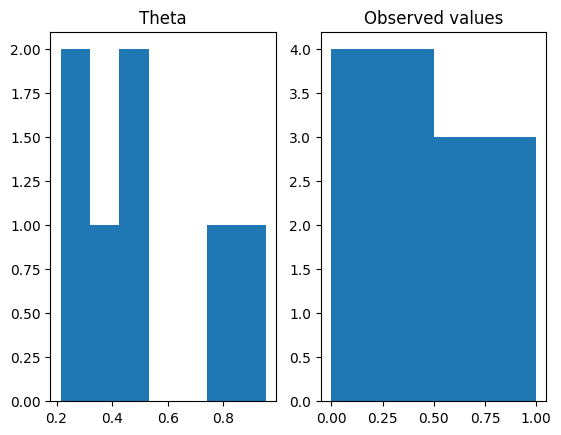

In [47]:
thetas = np.random.beta(1,1,7)
data   = np.random.binomial(1,theta)

fig,axs = plt.subplots(1,2)

ax=axs[0]
ax.hist(thetas,7)
ax.set_title("Theta")

ax=axs[1]
ax.hist(data,2)
ax.set_title("Observed values")

plt.show()

## Bayesian Learning

The goal of Bayesian learning (often called inference) is to estimate the probability density over parameter values.
In our above example, the goal would be that *given* a dataset ($\mathcal{D}$) to learn the probability density about $\theta$ or $p(\theta | \mathcal{D})$ where $\mathcal{D} = (0,1,0,1,1,0,1)$.

This inference task can be solved using Bayes theorem. 

\begin{align}
    p(\theta | \mathcal{D}) = \frac{p(\mathcal{D} | \theta) p(\theta)  }{p(\mathcal{D})}
\end{align}

where $p(\mathcal{D} | \theta)$ is the likelihood (from Frequentest statistics), $p(\theta)$ is called the prior probability about $\theta$, and $p(\mathcal{D})$ is typically called the evidence that our model generated the observed dataset. 

If we are only considering a single model then the evidence ($p(\mathcal{D})$) is a constant and we can write 

\begin{align}
    p(\theta | \mathcal{D}) \propto p(\mathcal{D} | \theta) p(\theta)
\end{align}

## Bayesian learning in infectious disease modeling (The goal)

In a typical infectious disease modeling setting, we are given a time series of observations.
We assume a reasonable epidemic model that could have generated this dataset, and the goal is to estimate parameters from this model. 
In a Bayesian setup, we are asked to estimate the probability density over our parameters. 

With a probability density over parameters in hand, we can compute densities over useful epidemiological quantities like the basic reproduction number, peak number number of infections, or we can forecast forward epidemiological quantities like the number of infections. 


For example, we may be given a series of observed incident infections. 
We assume that the pathogen moving through the host population follows typical SIR dynamics.
A typical Bayesian setup for this model may be 

\begin{align}
    I | \beta, \gamma = SIR( \beta,\gamma, S0,I0,R0 )\\
    \beta \sim \text{Gamma}(2,1)\\
    \gamma \sim \text{Beta}(5,1)\\
\end{align}

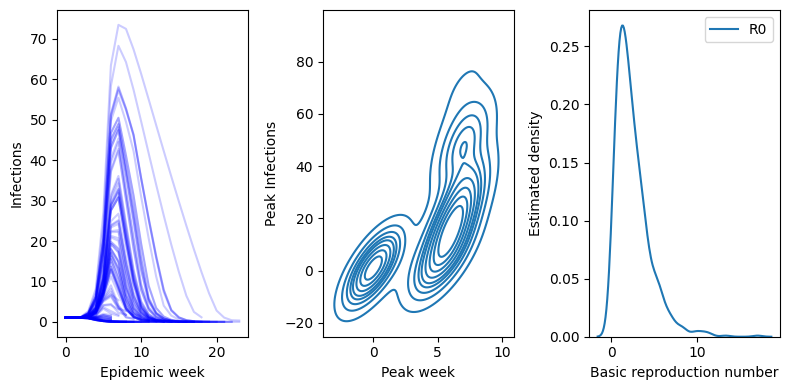

In [72]:
import numpy as np                     #--for array and matrix computations 
from scipy.integrate import solve_ivp  #--needed to solve the ODE system 
import matplotlib.pyplot as plt        #---for plotting 
import pandas as pd 
import seaborn as sns

def sirs(t,y,beta,gamma,n):
    s,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end  
    ds_dt = -beta*s*(i/n) 
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i 
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

betas  = np.random.gamma(2,1,800)
gammas = np.random.beta(5,1,800)

start,end = 0,15

#--set the number of S,I,R at time 0. 
S0 = 100
I0 = 1
R0 = 0.

#--Compute the total number of individuls (n)
n  = S0+I0+R0 

initial_conditions = (S0,I0,R0) #<--Grouped initial conditions into a tuple

fig,axs = plt.subplots(1,3,figsize=(8,4))

peaks = []
for (beta,gamma,phi) in zip(betas,gammas,phis):
    solution = solve_ivp( fun     = sirs
                         , t_span = (start,end)
                         , y0     = initial_conditions
                         , args   = (beta,gamma, n) )
    
    #--Extract solutions from the object called "solution"
    times = solution.t
    St    = solution.y[0,:] #<-first row  is S
    It   = solution.y[1,:] #<-second row is I
    Rt   = solution.y[2,:] #<-third row  is R

    axs[0].plot(It, color="blue", alpha=0.2)

    peaks.append( (np.argmax(It),np.max(It)) )

ax=axs[0]
ax.set_xlabel("Epidemic week")
ax.set_ylabel("Infections")

ax = axs[1]
peak_time,peak_value = zip(*peaks)
sns.kdeplot( pd.DataFrame({"peak_time":peak_time,"peak_value":peak_value}), x="peak_time", y="peak_value",ax=ax )

ax.set_xlabel("Peak week")
ax.set_ylabel("Peak Infections")

ax=axs[2]
sns.kdeplot( pd.DataFrame({"R0": betas/gammas }) ,ax=ax )

ax.set_xlabel("Basic reproduction number")
ax.set_ylabel("Estimated density")

fig.set_tight_layout(True)
plt.show()


\begin{align}
    \mu &\sim \mathcal{N}(m,s^2)\\
    X | \mu &\sim \mathcal{N}(\mu,\sigma^2)\\
\end{align}

\begin{align}
    p(\mu | \mathcal{D}) &= \frac{ p(\mathcal{D} | \mu ) p(\mu) }{ p(\mathcal{D})} \\ 
    &\propto p(\mathcal{D} | \mu ) p(\mu)
\end{align}

\begin{align}
    (2\pi\sigma^{2})^{-n/2} \exp \left[ -\frac{1}{2\sigma^{2}} \sum_{i=1}^{n} \left(x_{i}-\mu  \right)^{2}\right] \times (2\pi s^{2})^{-1/2} \exp \left[ -\frac{1}{2s^{2}} \left(\mu-m  \right)^{2}\right] \\ 
    (2\pi\sigma^{2})^{-n/2} \cdot (2\pi s^{2})^{-1/2} \times \exp -\frac{1}{2}\left[ \frac{1}{\sigma^{2}} \sum_{i=1}^{n} x^{2}_{i}-2 \mu \frac{1}{\sigma^{2}} \sum_{i=1}^{n} x_{i}  + \frac{1}{\sigma^{2}} n\mu^{2} +  \frac{1}{s^{2}} \mu^{2} - 2\mu m \frac{1}{s^{2}} + \frac{1}{s^{2}} m^{2} \right] \\ 
    (2\pi\sigma^{2})^{-n/2} \cdot (2\pi s^{2})^{-1/2} \times \exp -\frac{1}{2}\left[ \mu^{2} \left( \frac{n}{\sigma^{2}} + \frac{1}{s^{2}}  \right) - 2\mu \left( \frac{\sum_{i=1}^{n} x_{i}}{\sigma^{2}} + \frac{m}{s^{2}}  \right) \right]
\end{align}


\begin{align}
    \frac{1}{\tau^{2}}(\mu - M)^{2}\\
    \frac{\mu^{2}}{\tau^{2}} - 2\mu \frac{M}{\tau^{2}} + \frac{M^{2}}{\tau^{2}}
\end{align}

\begin{align}
    \frac{1}{\tau^{2}} &= \left( \frac{n}{\sigma^{2}} + \frac{1}{s^{2}}  \right) \\ 
    \frac{M}{\tau^{2}} &= \left( \frac{\sum_{i=1}^{n} x_{i}}{\sigma^{2}} + \frac{m}{s^{2}}  \right)\\
    M &= \tau^{2}\left( \frac{\sum_{i=1}^{n} x_{i}}{\sigma^{2}} + \frac{m}{s^{2}}  \right)
\end{align}

\begin{align}
    \tau^{2} &= \left( \frac{n}{\sigma^{2}} + \frac{1}{s^{2}}  \right)^{-1}\\
    M        &=  \frac{ \frac{\sum_{i=1}^{n} x_{i}}{\sigma^{2}} + \frac{m}{s^{2}} }{\frac{n}{\sigma^{2}} + \frac{1}{s^{2}} }\\
\end{align}


\begin{align}
    M &= \frac{ \frac{ n \bar{x}}{\sigma^{2}} + \frac{m}{s^{2}} }{\frac{n}{\sigma^{2}} + \frac{1}{s^{2}} }\\
\end{align}

\begin{align}
    M = \left(\frac{\frac{n}{\sigma^{2}}}{ \frac{n}{\sigma^{2}} + \frac{1}{s^{2}}}\right) \bar{x} + \left(\frac{\frac{1}{s^{2}}}{ \frac{n}{\sigma^{2}} + \frac{1}{s^{2}}}\right) m 
\end{align}

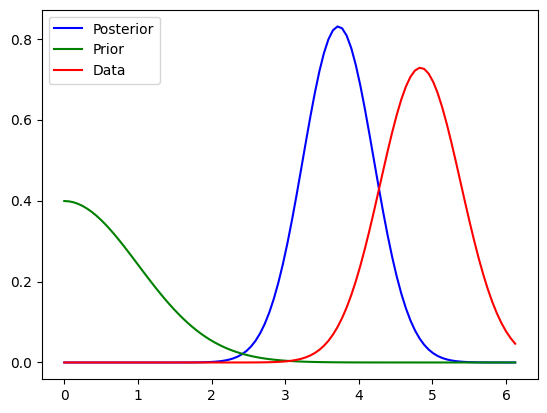

In [37]:
import numpy as np
import scipy.stats

n      = 10
sigma2 = 3

data = np.random.normal( loc=4,scale=sigma2, size=n )

m  = 0
s2 = 1

weight = ( n/sigma2 + 1/s2  )
xbar   = np.mean(data)

M      = ((n/sigma2)/weight)* xbar +  ((1/s2)/weight)*m


fig,ax = plt.subplots()

domain = np.linspace(0,M+5*np.sqrt(weight**-1),100)
posterior_pdf = scipy.stats.norm( M,np.sqrt(weight**-1))

prior_pdf = scipy.stats.norm( 0,np.sqrt(s2))
data_pdf  = scipy.stats.norm( xbar, np.sqrt(sigma2/n) )


ax.plot( domain, posterior_pdf.pdf(domain) , color="blue", label="Posterior")
ax.plot( domain, prior_pdf.pdf(domain), color="green", label="Prior" )
ax.plot( domain, data_pdf.pdf(domain), color="red",label="Data" )

ax.legend()
